# Style Transfer using VGG-16 Mode

#### References
- How to do style transfer in tensorflow: https://github.com/llSourcell/How_to_do_style_transfer_in_tensorflow
- The VGG 16 model: https://github.com/pkmital/CADL/blob/master/session-4/libs/vgg16.py

The majority of this code is taken from the [TensorFlow-Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials).

## Imports

In [1]:
%matplotlib inline
from IPython.display import Image, display
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import vgg16

#### Tensorflow version and GPU check

In [2]:
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### VGG-16 Model

In [3]:
import vgg16

#### Download VGG-16 data

Download in 'vgg16/' path the 550 MB of VGG-15 data

In [4]:
vgg16.data_dir = 'vgg16/'
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## Helper-functions

In [5]:
import helper

## Guatemalita

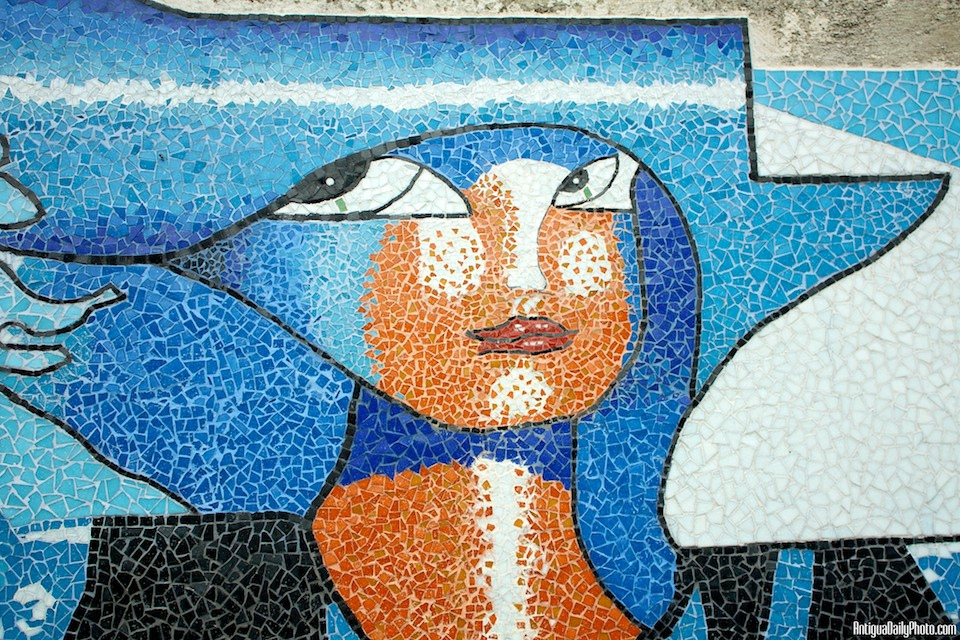

In [6]:
guatemalita_img = "efrain_recinos/guatemalita.jpg"
Image(guatemalita_img, width=343, height=512)

## Loss Functions

In [7]:
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [8]:
def create_content_loss(session, model, content_image, layer_ids):
    
    #A python dictionary object is generated with the 
    # placeholders as keys and the representative feed 
    #tensors as values.
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    # collection of filters
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        #because we are calculating losses per layer
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [9]:
#The Gram matrix, defined as https://i.stack.imgur.com/tU9ow.png 
#is used to 
#measure the correlation between channels after flattening the 
#filter images into vectors

#Gatys when asked why gram matrix at a talk was that the 
#Gram matrix encodes second 
#order statistics of the set of filters.
#it sort of mushes up all the features at a given layer, 
#tossing spatial information in favor of a measure of 
#how the different features are correlated 

def gram_matrix(tensor):
    #gram matrix is vector of dot products for vectors
    #of the feature activations of a style layer
    
    #4d tensor from convolutional layer
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    #-1 means whatever number makes the data fit 
    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    
    #gram matrix is transpose matrix with itself
    #so each entry in gram matrix
    #tells us if a feature channel has a tendency
    #to be activated with another feature channel
    
    #idea is to make the mixed image match patterns from style image
    
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram                            

In [10]:
def create_style_loss(session, model, style_image, layer_ids):
    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            
            
            #between gram matrix and value of gram matrix when inputting 
            #style image
            
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [11]:
#shifts input image by 1 pixel on x and y axis 
#calculate difference between shifted and original image
#absolute value to make positive
#calculate sum of pixels in those images
#helps suppress noise in mixed image we are generating

def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Style-Transfer 

In [12]:
#relative weights - normalized.
#style should have more weight than content
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):


    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    
    #adjust levels of loss functions, normalize them
    #multiply them with a variable
    #taking reciprocal values of loss values of content, style, denoising
    #small constant to avoid divide by 0
    #adjustment value normalizes loss so approximately 1
    #weights should be set relative to each other dont depend on layers
    #we are using
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image. (mixed)
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    #where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        #gradient descent
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            helper.plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    helper.plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## Guatemalita Style Transfer

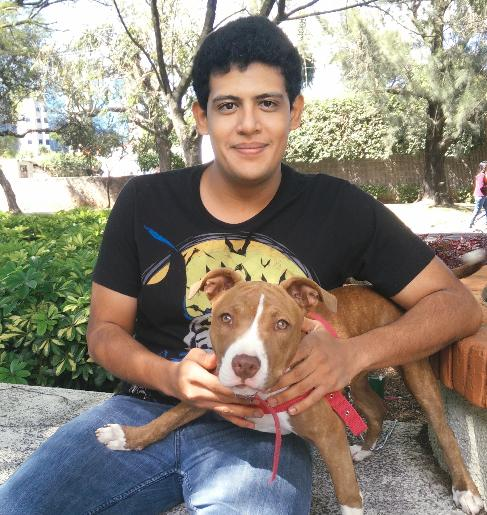

In [13]:
content_filename = 'test_images/willy_wonka_old.jpg'
content_filename = 'test_images/test.jpg'

content_image = helper.load_image(content_filename)
Image(content_filename, width=343, height=512)

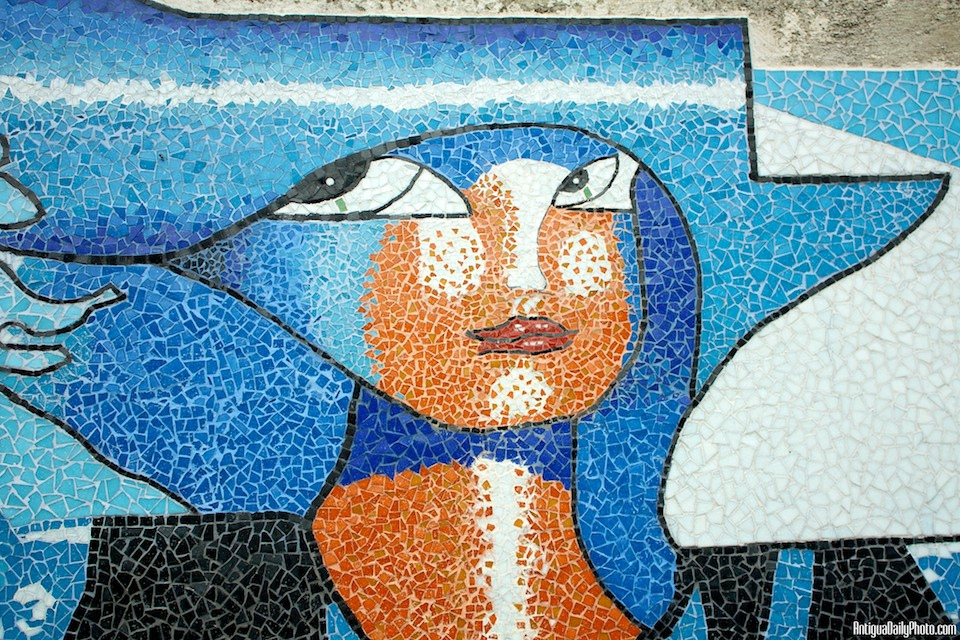

In [18]:
style_filename = guatemalita_img

style_image = helper.load_image(style_filename)
Image(style_filename, width=343, height=512)

In [19]:
content_layer_ids = [4]

# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 4.30e-11, Style: 5.14e-31, Denoise: 2.00e-06


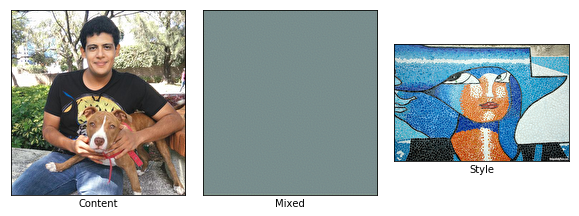

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 8.57e-11, Style: 2.39e-30, Denoise: 3.79e-08


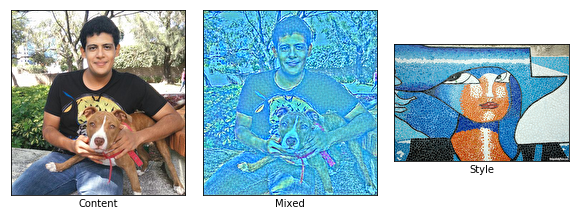

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 2.40e-11, Style: 6.90e-30, Denoise: 2.92e-08


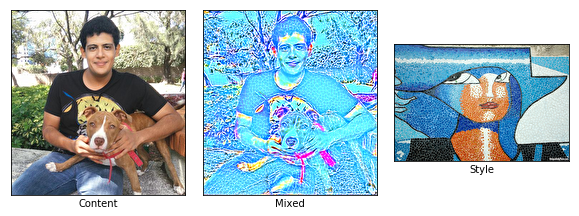

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 2.04e-11, Style: 9.12e-30, Denoise: 2.97e-08


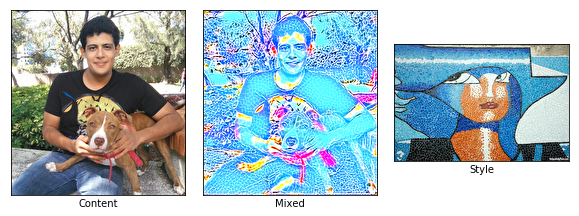

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.90e-11, Style: 1.05e-29, Denoise: 2.97e-08


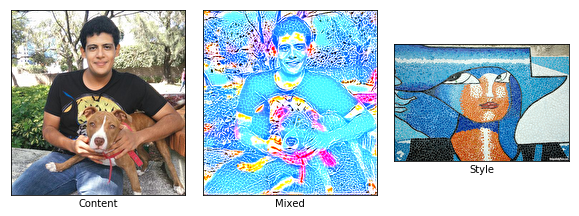

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.81e-11, Style: 1.16e-29, Denoise: 2.97e-08


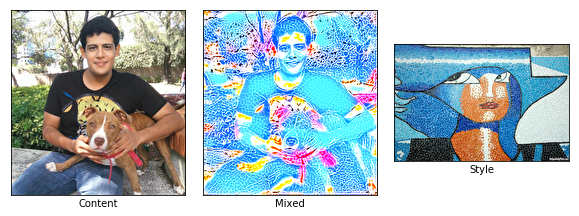

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 1.75e-11, Style: 1.24e-29, Denoise: 2.97e-08


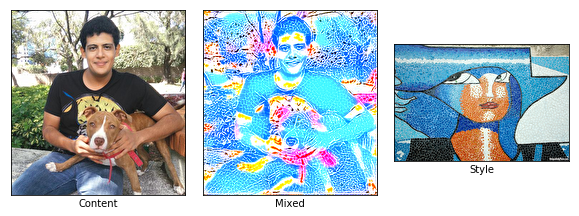

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 1.70e-11, Style: 1.30e-29, Denoise: 2.97e-08


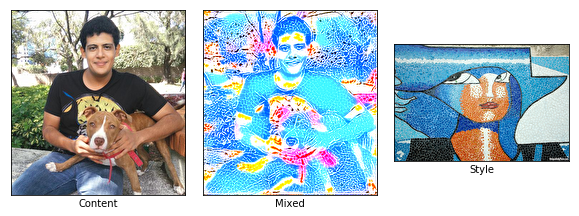

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 1.67e-11, Style: 1.35e-29, Denoise: 2.97e-08


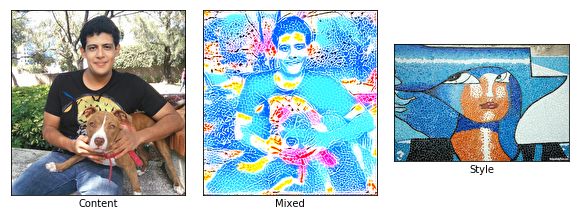

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 1.65e-11, Style: 1.38e-29, Denoise: 2.97e-08


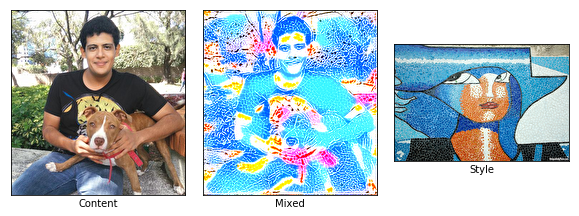

. . . . . . . . . . 
Iteration: 100
Weight Adj. for Content: 1.63e-11, Style: 1.41e-29, Denoise: 2.97e-08


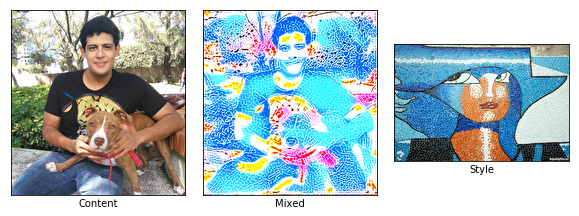

. . . . . . . . . . 
Iteration: 110
Weight Adj. for Content: 1.61e-11, Style: 1.44e-29, Denoise: 2.97e-08


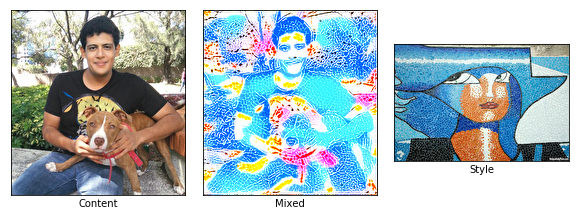

. . . . . . . . . . 
Iteration: 120
Weight Adj. for Content: 1.60e-11, Style: 1.46e-29, Denoise: 2.96e-08


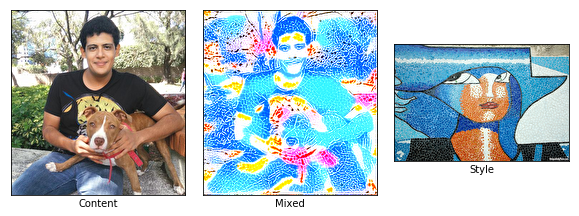

. . . . . . . 
Iteration: 127
Weight Adj. for Content: 1.62e-11, Style: 1.40e-29, Denoise: 2.96e-08


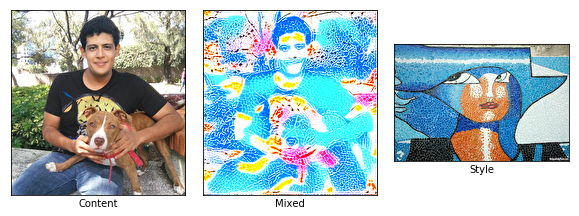


Final image:


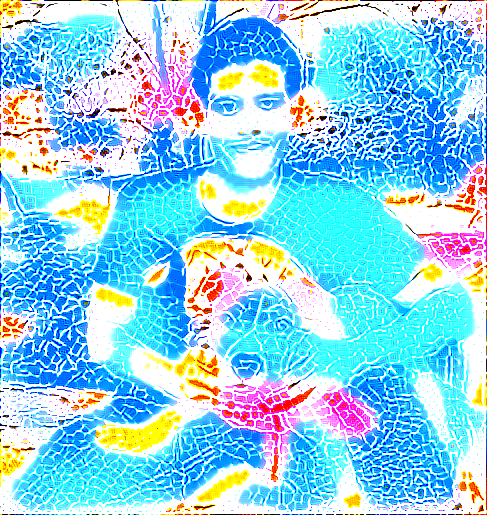

CPU times: user 37 s, sys: 13 s, total: 50 s
Wall time: 55.6 s


In [21]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=128,
                     step_size=10.0)